# Tutorial No. 3

## 1. Import Packages

In [12]:
from keras.models import Sequential,Model
from keras.layers import Dropout, BatchNormalization
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D

from keras.layers import Softmax
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import optimizers

import numpy as np
import cv2 
import os
from glob import glob
import matplotlib.pyplot as plt


## 2. Load Data

In [13]:
def read_data(directory):
# =============================================================================
#  This function gets a directory name and returns all images in it concatenated 
#  to each other
#  https://drive.google.com/drive/folders/1tZvSNCaH4TNmOgCJ-eBHyPRU9s7IBV20?usp=sharing 
# =============================================================================    
    data_list = glob(os.path.join('.','Data' + directory + '*.png'))
    data = np.asarray([cv2.imread(img,0) for img in data_list])
    return data

# read data from directory
x_train = read_data('\Train\Raw\\')
y_train = read_data('\Train\Seg\\')
x_test = read_data('\Test\Raw\\')
y_test = read_data('\Test\Seg\\')

# Change the shape to (n_clss)x(Height)x(Weight)x(channels)
x_train = (np.expand_dims(x_train, axis=3)).astype('float')
x_test =  (np.expand_dims(x_test, axis=3)).astype('float')

# Change labels to categorical
y_train = (to_categorical(y_train)).astype('float')
y_test = (to_categorical(y_test)).astype('float')

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


x_train shape: (704, 64, 80, 1)
x_test shape: (256, 64, 80, 1)
y_train shape: (704, 64, 80, 3)
y_test shape: (256, 64, 80, 3)


(-0.5, 79.5, 63.5, -0.5)

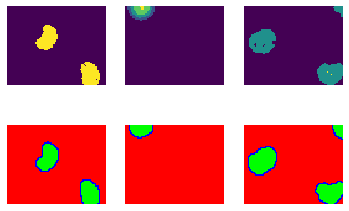

In [14]:
# visualize some images and their segmentation labels
plt.subplot(2,3,1)
plt.imshow(np.squeeze(x_train[150,:,:]))
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(np.squeeze(x_train[295,:,:]))
plt.axis('off')

plt.subplot(2,3,3)
plt.imshow(np.squeeze(x_train[650,:,:]))
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(y_train[150,:,:])
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(y_train[295,:,:])
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(y_train[650,:,:])
plt.axis('off')


## 3. Define Parameters 

In [15]:
num_of_clss = 3           # number of classes
lr =          1e-4        # learning rate 
beta_1 =      0.9         # beta 1 - for adam optimizer
beta_2 =      0.95        # beta 2 - for adam optimizer
epsilon =     1e-7        # epsilon - for adam optimizer
epochs =      50          # number of epochs
bs =          32          # batch size
dp =          0.5         # dropout probability


## 4. Build CNN Model

In [24]:
inp = Input(shape = (x_train.shape[1],x_train.shape[2],x_train.shape[3]))

# First conv block
x = Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(inp)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Second conv block
x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)
x = Dropout(dp)(x)

# Third conv block
x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = Conv2D(16, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# DECONV AND UNPOOLING

x = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = UpSampling2D((2, 2))(x)

x = Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', activation = 'relu')(x)
x = UpSampling2D((2, 2))(x)

out = Conv2DTranspose(num_of_clss, (3, 3), strides=(1, 1), padding='same', activation = 'softmax')(x)


model = Model(inp,out)




##  5. Compile the Model

In [25]:
# define the optimizer and compile the model
adam = optimizers.Adam(lr=lr, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# add early stopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5, verbose=1, mode='auto')


## 6. Train the Model

In [26]:
history = model.fit(x_train, y_train, validation_split=0.3, epochs=epochs, batch_size=bs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 492 samples, validate on 212 samples
Epoch 1/50
492/492 [==============================] - 6s 11ms/step - loss: 1.0504 - acc: 0.6704 - val_loss: 0.9455 - val_acc: 0.9322
Epoch 2/50
492/492 [==============================] - 0s 759us/step - loss: 0.8252 - acc: 0.9482 - val_loss: 0.8255 - val_acc: 0.9389
Epoch 3/50
492/492 [==============================] - 0s 782us/step - loss: 0.5226 - acc: 0.9503 - val_loss: 0.6464 - val_acc: 0.9390
Epoch 4/50
492/492 [==============================] - 0s 775us/step - loss: 0.2232 - acc: 0.9509 - val_loss: 0.3287 - val_acc: 0.9388
Epoch 5/50
492/492 [==============================] - 0s 779us/step - loss: 0.1503 - acc: 0.9537 - val_loss: 0.2135 - val_acc: 0.9411
Epoch 6/50
492/492 [==============================] - 0s 775us/step - loss: 0.1263 - acc: 0.9582 - val_loss: 0.1825 - val_acc: 0.9505
Epoch 7/50
492/492 [==============================] - 0

## 7. Visualize

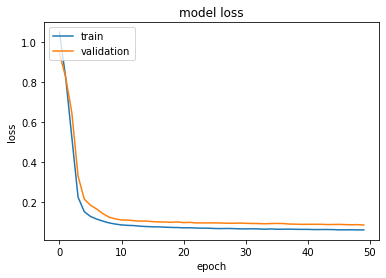

In [27]:
# plot train and validation loss 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show(); plt.close()


## 8. Model Evaluation

256/256 [==============================] - 0s 299us/step
test loss: 0.08348353020846844
test accuracy: 0.9719970673322678


(-0.5, 79.5, 63.5, -0.5)

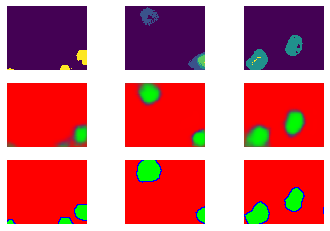

In [28]:
y_pred = model.predict(x_test)
test_loss, test_acc = model.evaluate(x_test, y_test)

# Print results
print('test loss:', test_loss)
print('test accuracy:', test_acc)

# visualize some images with their prediction and true labels
plt.subplot(3,3,1)
plt.imshow(np.squeeze(x_test[10,:,:]))
plt.axis('off')

plt.subplot(3,3,2)
plt.imshow(np.squeeze(x_test[20,:,:]))
plt.axis('off')

plt.subplot(3,3,3)
plt.imshow(np.squeeze(x_test[30,:,:]))
plt.axis('off')

plt.subplot(3,3,4)
plt.imshow(y_pred[10,:,:])
plt.axis('off')

plt.subplot(3,3,5)
plt.imshow(y_pred[20,:,:])
plt.axis('off')

plt.subplot(3,3,6)
plt.imshow(y_pred[30,:,:])
plt.axis('off')

plt.subplot(3,3,7)
plt.imshow(y_test[10,:,:])
plt.axis('off')

plt.subplot(3,3,8)
plt.imshow(y_test[20,:,:])
plt.axis('off')

plt.subplot(3,3,9)
plt.imshow(y_test[30,:,:])
plt.axis('off')